## exp001

baseline
 -> カテゴリカルコンビネーション
r=2

PrivateLB下がった



CV | 15099.348221218475

PrivateLB | 26770.98

In [26]:
MODEL_NAME = 'exp001'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from functools import partial

import lightgbm as lgb

import json

from xfeat import SelectCategorical, LabelEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer

In [3]:
import time

from contextlib import contextmanager


@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

In [4]:
df_train = pd.read_csv('./input/train.csv')
df_test = pd.read_csv('./input/test.csv')

In [5]:
numeric_columns = ['index','Order', 'MS SubClass', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', '1st Flr SF',
       '2nd Flr SF', 'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Wood Deck SF',
       'Open Porch SF', 'Mo Sold', 'Yr Sold', 'SalePrice']

string_columns = ['MS Zoning', 'Lot Shape', 'Land Contour', 'Lot Config', 'Neighborhood',
       'Bldg Type', 'House Style', 'Roof Style', 'Exterior 1st',
       'Exterior 2nd', 'Exter Qual', 'Foundation', 'Heating QC', 'Central Air',
       'Electrical', 'Kitchen Qual', 'Paved Drive', 'Sale Type',
       'Sale Condition']

In [6]:
def pre_process(df, phase='train'):
    df = df.drop(['Wood Deck SF'], axis=1)
    df = df.drop(['Lot Config'], axis=1)
    df = df.drop(['Land Contour'], axis=1)
    df = df.drop(['Kitchen AbvGr'], axis=1)
    df = df.drop(['Central Air'], axis=1)
    df = df.drop(['Electrical'], axis=1)
    df = df.drop(['2nd Flr SF'], axis=1)
    df = df.drop(['Paved Drive'], axis=1)
    df = df.drop(['Open Porch SF'], axis=1)

    if(phase == 'train'):
        df = df[df['MS SubClass'] < 150]
        df = df[df['Lot Area'] < 15000]
        df = df[df['1st Flr SF'] < 1800]
        df = df[(df['SalePrice'] > 100000) & (df['SalePrice'] < 200000)]
    
    return df

In [7]:
df_train = pre_process(df_train, phase="train")
df_test = pre_process(df_test, phase="test")

In [8]:
encoder = Pipeline([
    SelectCategorical(exclude_cols=[]),
    ConcatCombination(output_suffix="_re", r=2),
    LabelEncoder(output_suffix=""),
])
encoded_df_train = encoder.fit_transform(df_train)
encoded_df_test = encoder.transform(df_test)

In [9]:
encoded_df_train

,MS Zoning,Lot Shape,Neighborhood,Bldg Type,House Style,Roof Style,Exterior 1st,Exterior 2nd,Exter Qual,Foundation,...,FoundationHeating QC_re,FoundationKitchen Qual_re,FoundationSale Type_re,FoundationSale Condition_re,Heating QCKitchen Qual_re,Heating QCSale Type_re,Heating QCSale Condition_re,Kitchen QualSale Type_re,Kitchen QualSale Condition_re,Sale TypeSale Condition_re
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,1,1,...,1,1,1,1,1,0,0,1,1,0
2,0,0,2,0,0,1,0,0,1,1,...,1,1,1,1,1,0,0,1,1,0
3,0,0,3,0,1,0,0,1,0,0,...,2,0,0,0,2,1,1,0,0,0
4,0,0,4,0,0,0,0,0,1,1,...,1,1,1,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,0,0,3,0,1,0,0,1,0,0,...,2,0,0,0,2,1,1,0,0,0
2995,0,0,2,2,0,0,0,0,0,1,...,1,2,1,1,0,0,0,0,0,0
2997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2998,2,0,10,0,2,0,0,0,1,1,...,1,2,1,1,0,0,0,0,0,0


In [10]:
# def remove_features(df):
#     df = df.drop(['Bldg Type','Roof Style','Roof StyleSale Type_re','Sale Type',
#                   'Sale Condition','Bldg TypeRoof Style_re','Sale TypeSale Condition_re',], axis=1)

# encoded_df_train = remove_features(encoded_df_train)
# encoded_df_test = remove_features(encoded_df_test)

In [11]:
df_train = pd.concat([SelectNumerical().fit_transform(df_train), encoded_df_train], axis=1)
df_test = pd.concat([SelectNumerical().fit_transform(df_test), encoded_df_test], axis=1)

In [12]:
X_train = df_train.drop(['index', 'SalePrice'], axis=1)
y_train = df_train['SalePrice']

In [13]:
folds = KFold(n_splits=5, shuffle=True,random_state=42)

In [14]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': -1
}

In [15]:
# from optuna.integration import lightgbm as lgb_op

# best_params = {}

# with timer("wait"):
#     for train_index, val_index in folds.split(X_train, y_train):
#         lgb_train = lgb.Dataset(X_train.iloc[train_index], y_train.iloc[train_index])
#         lgb_eval = lgb.Dataset(X_train.iloc[val_index], y_train.iloc[val_index], reference=lgb_train)
#         best = lgb_op.train(params,
#                          lgb_train,
#                          valid_sets=lgb_eval,
#                          verbose_eval=False,
#                          num_boost_round=1000,
#                          early_stopping_rounds=30,
#                         )
#         best_params = (best.params)
#         break

# best_params

In [16]:
params = {'objective': 'regression',
             'metric': 'rmse',
             'verbose': -1,
             'feature_pre_filter': False,
             'lambda_l1': 1.9246603611247695,
             'lambda_l2': 0.0015207873611208637,
             'num_leaves': 45,
             'feature_fraction': 0.616,
             'bagging_fraction': 1.0,
             'bagging_freq': 0,
             'min_child_samples': 20,
}

In [17]:
#folds = KFold(n_splits=5, shuffle=True,random_state=42)

lgb_train = lgb.Dataset(X_train, y_train)

model = lgb.cv(params,
                 lgb_train,
                 folds=folds,
                 num_boost_round=1000,
                 early_stopping_rounds=10,
                 return_cvbooster=True,
                )

cv_score = model['rmse-mean'][-1]

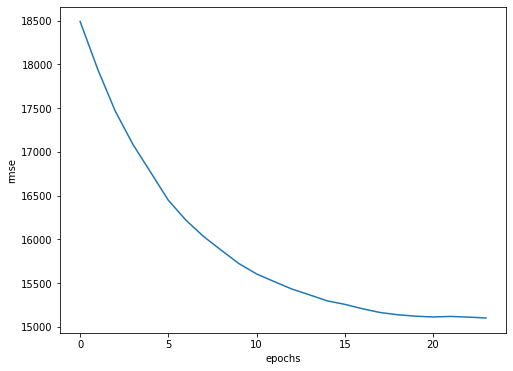

In [18]:
_,ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('epochs')
ax.set_ylabel('rmse')
ax.plot(np.arange(0,len(model['rmse-mean'])),model['rmse-mean'])

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

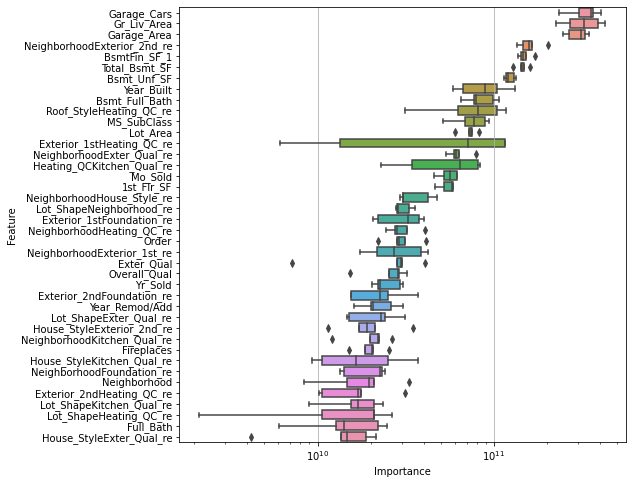

In [25]:
cvbooster = model['cvbooster']

raw_importances = cvbooster.feature_importance(importance_type='gain')
feature_names = cvbooster.boosters[0].feature_name()
df_importance = pd.DataFrame(data=raw_importances, columns=feature_names)

# 平均値ソート
sorted_indices = df_importance.mean(axis=0).sort_values(ascending=False).index
sorted_df_importance = df_importance.loc[:, sorted_indices]

PLOT_TOP_N = 40
plot_cols = sorted_df_importance.columns[:PLOT_TOP_N]
_, ax = plt.subplots(figsize=(8,8))
ax.grid()
ax.set_xscale('log')
ax.set_ylabel('Feature')
ax.set_xlabel('Importance')
sns.boxplot(data=sorted_df_importance[plot_cols],
           orient='h',
           ax=ax)

In [20]:
X_test = df_test.drop(['index'], axis=1)

predicted = np.zeros(X_test.shape[0])
for i in np.arange(len(cvbooster.boosters)):
    predicted += cvbooster.boosters[i].predict(X_test) / len(cvbooster.boosters)

output = pd.DataFrame({'index':df_test['index'],'predicted': predicted})
output.to_csv('./output/submit.csv', index=False, header=False)

In [21]:
import json
import datetime

meta = {
    'model':MODEL_NAME,
    'cv_score':cv_score,
    'created_at':datetime.datetime.now().strftime('%Y%m%d%H%M%S')
}

with open('./output/submit.json', 'w') as f:
    json.dump(meta, f)

In [22]:
importance_mean = sorted_df_importance.mean(axis=0)
importance_mean

Garage_Cars                    3.334794e+11
Gr_Liv_Area                    3.268120e+11
Garage_Area                    2.995123e+11
NeighborhoodExterior_2nd_re    1.618384e+11
BsmtFin_SF_1                   1.494986e+11
                                   ...     
Roof_StyleSale_Type_re         0.000000e+00
Sale_Type                      0.000000e+00
Sale_Condition                 0.000000e+00
Bldg_TypeRoof_Style_re         0.000000e+00
Sale_TypeSale_Condition_re     0.000000e+00
Length: 127, dtype: float64

In [23]:
importance_mean[importance_mean < 10 ** 9]

Bldg_TypeHeating_QC_re           960241920.0
Lot_ShapeSale_Condition_re       946843545.6
Kitchen_Qual                     930883180.8
Roof_StyleExterior_1st_re        915174617.6
Heating_QC                       888983379.2
Bldg_TypeSale_Condition_re       838042112.0
Bldg_TypeSale_Type_re            689083520.0
Exterior_2ndSale_Condition_re    652287756.8
House_StyleSale_Condition_re     578579065.6
Bldg_TypeExter_Qual_re           534447347.2
Lot_ShapeRoof_Style_re           492288524.8
Kitchen_QualSale_Condition_re    410800870.4
MS_ZoningSale_Condition_re       207658726.4
MS_Zoning                        199726937.6
Roof_StyleSale_Condition_re      186169689.6
MS_ZoningRoof_Style_re           174738688.0
Lot_ShapeSale_Type_re            149692979.2
MS_ZoningSale_Type_re            107515993.6
Bldg_Type                                0.0
Roof_Style                               0.0
Roof_StyleSale_Type_re                   0.0
Sale_Type                                0.0
Sale_Condi

In [24]:
print(cv_score)

15099.348221218475
